# Handling missing values

In the process of data preprocessing, the bolded out point below is the focus of this notebook.

Plan:

- Transform data
    - Pretend current wind predictions are measurements
    - Split into a measurement dataframe (enc_df) and a forecasting df (dec_df)
    - Transform degrees into cos and sin values

- Divide into parks, and for each park:
    - **Overview over NaN values and how to deal with them**
    - Autocorrelation over wind speed, wind direction, production
    - How much does the wind speed and wind direction change when the forecast is updated?
    - How is the wind speed and the production correlated?

- Look at data for all parks
    - Normalize data for all parks (max production at each park is 1)
    - Look at correlations between production at the different parks
    - Look at correlations again, this time after splitting the data into wind direction quadrant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import sys
import os
from satprod.data_handlers.data_utils import get_columns
from satprod.data_handlers.num_data import NumericalDataHandler

pd.set_option("display.max_rows", 700, "display.max_columns", 50)

## Test set notice

All observations after 30.04.2020 23:00:00 are considered unknown, and won't be analysed or used in making model decisions or when deciding how to fill NaN values. The reason for setting this date is that the goal in the end is to have one year of test set data (01.05.2020 00:00:00 - 30.04.2021 23:00:00) to test the models on.

In [2]:
split = datetime(2020, 5, 1, 0)
num = NumericalDataHandler()
data = num.read_formatted_data(nan=True)
data = data[data.index < split]

## Missing values in wind data

In [3]:
get_columns(data, 'wind').isna().sum()

wind_speed_bess               365
wind_speed_skom               365
wind_speed_vals               365
wind_speed_yvik               365
wind_direction_bess_cos       365
wind_direction_bess_sin       365
wind_direction_skom_cos       365
wind_direction_skom_sin       365
wind_direction_vals_cos       365
wind_direction_vals_sin       365
wind_direction_yvik_cos       365
wind_direction_yvik_sin       365
wind_speed_bess+1h            366
wind_speed_bess+2h            367
wind_speed_bess+3h            368
wind_speed_bess+4h            369
wind_speed_bess+5h            370
wind_speed_bess+6h            372
wind_speed_skom+1h            366
wind_speed_skom+2h            367
wind_speed_skom+3h            368
wind_speed_skom+4h            369
wind_speed_skom+5h            370
wind_speed_skom+6h            372
wind_speed_vals+1h            366
wind_speed_vals+2h            367
wind_speed_vals+3h            368
wind_speed_vals+4h            369
wind_speed_vals+5h            370
wind_speed_val

In [4]:
get_columns(data, 'wind').asfreq('H')[get_columns(data, 'wind').asfreq('H').isna().any(axis=1)]

,wind_speed_bess,wind_speed_skom,wind_speed_vals,wind_speed_yvik,wind_direction_bess_cos,wind_direction_bess_sin,wind_direction_skom_cos,wind_direction_skom_sin,wind_direction_vals_cos,wind_direction_vals_sin,wind_direction_yvik_cos,wind_direction_yvik_sin,wind_speed_bess+1h,wind_speed_bess+2h,wind_speed_bess+3h,wind_speed_bess+4h,wind_speed_bess+5h,wind_speed_bess+6h,wind_speed_skom+1h,wind_speed_skom+2h,wind_speed_skom+3h,wind_speed_skom+4h,wind_speed_skom+5h,wind_speed_skom+6h,wind_speed_vals+1h,...,wind_direction_skom_sin+6h,wind_direction_vals_cos+1h,wind_direction_vals_cos+2h,wind_direction_vals_cos+3h,wind_direction_vals_cos+4h,wind_direction_vals_cos+5h,wind_direction_vals_cos+6h,wind_direction_vals_sin+1h,wind_direction_vals_sin+2h,wind_direction_vals_sin+3h,wind_direction_vals_sin+4h,wind_direction_vals_sin+5h,wind_direction_vals_sin+6h,wind_direction_yvik_cos+1h,wind_direction_yvik_cos+2h,wind_direction_yvik_cos+3h,wind_direction_yvik_cos+4h,wind_direction_yvik_cos+5h,wind_direction_yvik_cos+6h,wind_direction_yvik_sin+1h,wind_direction_yvik_sin+2h,wind_direction_yvik_sin+3h,wind_direction_yvik_sin+4h,wind_direction_yvik_sin+5h,wind_direction_yvik_sin+6h
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-11 23:00:00,2.016363,2.016363,9.255204,2.564329,-0.507365,0.861731,-0.507365,0.861731,0.639031,-0.769181,-0.700994,0.713167,0.956984,7.935425,8.252768,8.634879,8.645044,NaN,0.956984,7.935425,8.252768,8.634879,8.645044,NaN,7.010409,...,-0.707107,0.522926,0.833275,0.987187,0.999542,0.853643,-0.707107,-0.852378,-0.552859,-0.159565,0.030264,-0.520858,-0.707107,-0.713446,-0.644170,-0.859601,0.875751,0.848269,-0.707107,0.700710,0.764883,0.510965,-0.482762,-0.529566,-0.707107
2018-05-13 19:00:00,3.729789,3.729789,0.864454,5.220606,-0.331961,0.943293,-0.331961,0.943293,0.958408,-0.285401,0.835389,0.549660,4.136873,4.533954,4.566402,4.450626,4.645537,NaN,4.136873,4.533954,4.566402,4.450626,4.645537,NaN,1.109870,...,NaN,-0.283827,-0.761833,-0.940157,-0.962720,-0.989538,NaN,-0.958875,-0.647773,-0.340740,-0.270502,-0.144272,NaN,0.823622,0.763832,0.447421,-0.493133,-0.739244,NaN,0.567139,0.645415,0.894323,0.869954,0.673438,NaN
2018-05-13 20:00:00,4.136873,4.136873,1.109870,4.955759,-0.419882,0.907579,-0.419882,0.907579,-0.283827,-0.958875,0.823622,0.567139,4.533954,4.566402,4.450626,4.645537,NaN,NaN,4.533954,4.566402,4.450626,4.645537,NaN,NaN,1.307788,...,NaN,-0.761833,-0.940157,-0.962720,-0.989538,NaN,NaN,-0.647773,-0.340740,-0.270502,-0.144272,NaN,NaN,0.763832,0.447421,-0.493133,-0.739244,NaN,NaN,0.645415,0.894323,0.869954,0.673438,NaN,NaN
2018-05-13 21:00:00,4.533954,4.533954,1.307788,4.458501,-0.528495,0.848936,-0.528495,0.848936,-0.761833,-0.647773,0.763832,0.645415,4.566402,4.450626,4.645537,NaN,NaN,NaN,4.566402,4.450626,4.645537,NaN,NaN,NaN,1.489956,...,NaN,-0.940157,-0.962720,-0.989538,NaN,NaN,NaN,-0.340740,-0.270502,-0.144272,NaN,NaN,NaN,0.447421,-0.493133,-0.739244,NaN,NaN,NaN,0.894323,0.869954,0.673438,NaN,NaN,NaN
2018-05-13 22:00:00,4.566402,4.566402,1.489956,2.837621,-0.563049,0.826423,-0.563049,0.826423,-0.940157,-0.340740,0.447421,0.894323,4.450626,4.645537,NaN,NaN,NaN,NaN,4.450626,4.645537,NaN,NaN,NaN,NaN,1.596348,...,NaN,-0.962720,-0.989538,NaN,NaN,NaN,NaN,-0.270502,-0.144272,NaN,NaN,NaN,NaN,-0.493133,-0.739244,NaN,NaN,NaN,NaN,0.869954,0.673438,NaN,NaN,NaN,NaN
2018-05-13 23:00:00,4.450626,4.450626,1.596348,2.724880,-0.488111,0.872781,-0.488111,0.872781,-0.962720,-0.270502,-0.493133,0.869954,4.645537,NaN,NaN,NaN,NaN,NaN,4.645537,NaN,NaN,NaN,NaN,NaN,1.894965,...,NaN,-0.989538,NaN,NaN,NaN,NaN,NaN,-0.144272,NaN,NaN,NaN,NaN,NaN,-0.739244,NaN,NaN,NaN,NaN,NaN,0.673438,NaN,NaN,NaN,NaN,NaN
2018-05-14 00:00:00,4.645537,4.645537,1.894965,3.479148,-0.438189,0.898883,-0.438189,0.898883,-0.989538,-0.144272,-0.739244,0.673438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-14 01:00:00,NaN,NaN,NaN,NaN,

### Conclusion missing wind data

Drop columns from and including 2018-05-12 00:00:00 until and including 2018-05-29 05:00:00. This accounts for all the missing data, that is unobtainable other than through guessing the wind by using the production data. This would still leave missing values for wind direction data, and so the data is certain to be dropped.

In [5]:
data = data.dropna(subset=get_columns(data, 'wind').columns)

# drop additional rows before as well, since these are forecasts done several hours before (up to 66 hours before)
start_remove = pd.to_datetime('2018-05-12 00:00:00')
end_remove = pd.to_datetime('2018-05-14 00:00:00')
data = data.query('index < @start_remove or index > @end_remove')

In [6]:
get_columns(data, 'wind').isna().sum()

wind_speed_bess               0
wind_speed_skom               0
wind_speed_vals               0
wind_speed_yvik               0
wind_direction_bess_cos       0
wind_direction_bess_sin       0
wind_direction_skom_cos       0
wind_direction_skom_sin       0
wind_direction_vals_cos       0
wind_direction_vals_sin       0
wind_direction_yvik_cos       0
wind_direction_yvik_sin       0
wind_speed_bess+1h            0
wind_speed_bess+2h            0
wind_speed_bess+3h            0
wind_speed_bess+4h            0
wind_speed_bess+5h            0
wind_speed_bess+6h            0
wind_speed_skom+1h            0
wind_speed_skom+2h            0
wind_speed_skom+3h            0
wind_speed_skom+4h            0
wind_speed_skom+5h            0
wind_speed_skom+6h            0
wind_speed_vals+1h            0
wind_speed_vals+2h            0
wind_speed_vals+3h            0
wind_speed_vals+4h            0
wind_speed_vals+5h            0
wind_speed_vals+6h            0
wind_speed_yvik+1h            0
wind_spe

In [7]:
data.loc['2018-05-11 23:00:00':'2018-05-29 06:00:00']

,wind_speed_bess,wind_speed_skom,wind_speed_vals,wind_speed_yvik,wind_direction_bess_cos,wind_direction_bess_sin,wind_direction_skom_cos,wind_direction_skom_sin,wind_direction_vals_cos,wind_direction_vals_sin,wind_direction_yvik_cos,wind_direction_yvik_sin,wind_speed_bess+1h,wind_speed_bess+2h,wind_speed_bess+3h,wind_speed_bess+4h,wind_speed_bess+5h,wind_speed_bess+6h,wind_speed_skom+1h,wind_speed_skom+2h,wind_speed_skom+3h,wind_speed_skom+4h,wind_speed_skom+5h,wind_speed_skom+6h,wind_speed_vals+1h,...,wind_direction_vals_cos+4h,wind_direction_vals_cos+5h,wind_direction_vals_cos+6h,wind_direction_vals_sin+1h,wind_direction_vals_sin+2h,wind_direction_vals_sin+3h,wind_direction_vals_sin+4h,wind_direction_vals_sin+5h,wind_direction_vals_sin+6h,wind_direction_yvik_cos+1h,wind_direction_yvik_cos+2h,wind_direction_yvik_cos+3h,wind_direction_yvik_cos+4h,wind_direction_yvik_cos+5h,wind_direction_yvik_cos+6h,wind_direction_yvik_sin+1h,wind_direction_yvik_sin+2h,wind_direction_yvik_sin+3h,wind_direction_yvik_sin+4h,wind_direction_yvik_sin+5h,wind_direction_yvik_sin+6h,production_bess,production_skom,production_vals,production_yvik
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-11 23:00:00,2.759556,2.759556,2.071460,2.359555,-0.017959,0.999839,-0.017959,0.999839,0.539968,0.841686,0.918840,0.394630,3.175081,4.759763,4.676367,3.570887,2.456317,2.706656,3.175081,4.759763,4.676367,3.570887,2.456317,2.706656,1.993259,...,0.582721,0.680699,0.769481,0.904257,0.876630,0.751887,0.812672,0.732563,0.638670,0.658485,-0.050249,-0.502139,-0.726236,-0.762270,-0.753754,0.752594,0.998737,0.864787,0.687446,0.647259,0.657157,1.509317,0.485783,0.126102,1.904300
2018-05-29 06:00:00,3.431179,3.431179,2.600671,3.603380,0.368714,-0.929543,0.368714,-0.929543,0.677967,-0.735092,0.436811,-0.899553,3.902290,2.548192,3.187027,4.041606,4.666240,4.999129,3.902290,2.548192,3.187027,4.041606,4.666240,4.999129,3.862395,...,0.888736,0.910385,0.962377,-0.549599,-0.314657,-0.299595,-0.458419,-0.413762,-0.271717,0.371159,0.397066,0.456415,0.556127,0.692038,0.781392,-0.928569,-0.917790,-0.889767,-0.831097,-0.721861,-0.624041,1.092767,0.097000,0.136451,3.166117


## Missing values in production data

In [8]:
get_columns(data, 'production').isna().sum()

production_bess      59
production_skom     110
production_vals       0
production_yvik    4636
dtype: int64

In [9]:
get_columns(data, 'production').interpolate(limit=1).isna().sum()

production_bess      34
production_skom      81
production_vals       0
production_yvik    4529
dtype: int64

Interpolation shows that a lot of the missing values are alone in between other values. However, let's look more at the missing values compared to the wind speed before deciding to use interpolation.

There are a lot of missing values for the yvik park. However, a lot of them appear before the satellite images are available (March 2018).

In [10]:
get_columns(data, 'production').loc['2018-03-20 00:00:00':].isna().sum()

production_bess      59
production_skom      58
production_vals       0
production_yvik    3467
dtype: int64

Above shows that there are less than 200 missing values per park after the satellite images appear. But before removing the data that is before the images come into play, let's see if patterns in the data from 2017 can be used to fill the rest of the missing data.

In [11]:
get_columns(data, 'production').loc['2018-03-20 00:00:00':][
    get_columns(data, 'production').loc['2018-03-20 00:00:00':].isna().any(axis=1)]

,production_bess,production_skom,production_vals,production_yvik
time,,,,
2018-03-28 09:00:00,13.968600,5.932333,1.335506,NaN
2018-03-28 10:00:00,10.772533,4.641183,0.976408,NaN
2018-03-28 11:00:00,10.912999,7.346017,0.439778,NaN
2018-03-28 20:00:00,11.939466,2.461000,0.269307,NaN
2018-03-28 21:00:00,12.307416,2.791500,0.272095,NaN
...,...,...,...,...
2020-04-30 19:00:00,29.109812,10.979547,3.119000,NaN
2020-04-30 20:00:00,29.709590,11.268191,2.662000,NaN
2020-04-30 21:00:00,31.054506,12.731776,3.027000,NaN


As one can see, there are rarely periods of missing values that lasts more than two-three days, and most of them are just for a few hours. This should be possible to fix using our wind measurements, and the fact that the production is should be approximately proportional to the wind speed cubed.

The goal here is not to go in-depth to predict the missing production values. However, when a well-functioning power prediction model is up and running, one could go back and use it to predict these missing values, and compare the prediction to what was filled in before training using the simple method that we'll use now.

Simply using that the power production is the wind speed cubed times some constant $\alpha$, would probably be to simplyfy too much. The proportionality constant $\alpha$ is probably changing depending on the wind speed, something that will be accounted for numerically. At the time of a missing production value at a given park, let's say the wind speed was measured to be $4.1$ m/s. Then, all the timepoints before the given time where the wind speed has been between $4.1 - 1.0$ m/s and $4.1 + 1.0$ m/s, are gathered, and for each of these timepoints, the measured production is divided by the corresponding wind speed. The result is a list of estimations of $\alpha$, one for each timepoint within the given windspeed interval. Taking the mean of these estimations, gives a value for alpha, and the missing production value is replaced with $\alpha \times 4.1^3$.

Below is a prediction function using the method described in the previous paragraph. It can aesily be tested by changing the constants below the function.

In [12]:
dir(num)

['_NumericalDataHandler__direction_transforms',
 '_NumericalDataHandler__get_model_preds',
 '_NumericalDataHandler__infer_missing_prod_value',
 '_NumericalDataHandler__insert_missing_values',
 '_NumericalDataHandler__read_prod_data',
 '_NumericalDataHandler__read_wind_data',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'fill_missing_values',
 'formatted_data_path',
 'get_prod_data',
 'get_wind_data',
 'parks',
 'pred_limit',
 'raw_data_path',
 'read_formatted_data',
 'root',
 'train_test_split',
 'update_formatted_files',
 'write_formatted_data']

In [13]:
# constants up for changing
days = 30
numhours = 24*days
year = 2019
base = datetime(year, 1, 1, 0)
times = [base + timedelta(hours=x) for x in range(numhours)]
park = 'yvik'

In [14]:
pred_prods = []
real_prods = []

for i in range(len(times)):
    pred_prod, real_prod = num._NumericalDataHandler__infer_missing_prod_value(
        data, times[i], park, real_prod_exists=True, only_use_seen_data=True)
    pred_prods.append(pred_prod)
    real_prods.append(real_prod)

In [15]:
mse = np.sqrt(np.mean(np.square(np.array(pred_prods)-np.array(real_prods))))

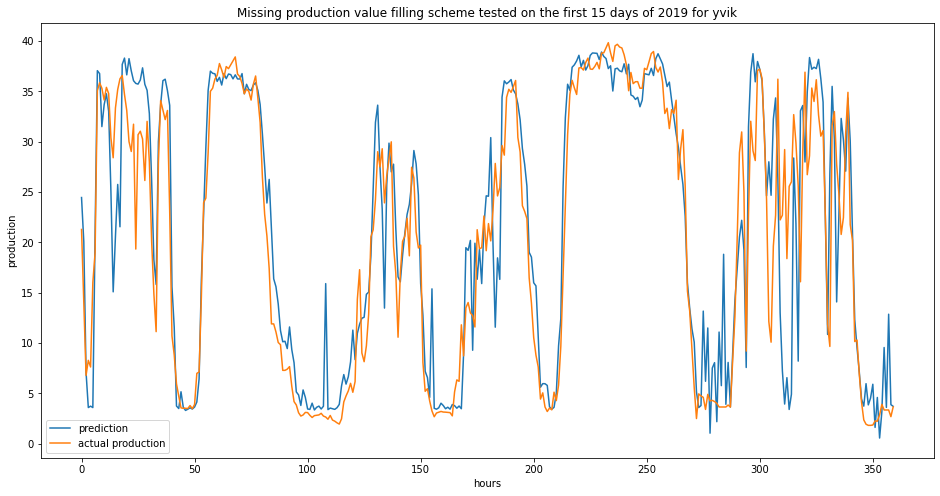

Root mean squared error for the predictions for the first 30 days of 2019 at yvik was 5.519122632030527


In [16]:
start = 0
first_days = 15
stop = 24*first_days
plt.figure(figsize=(16,8))
plt.plot(pred_prods[start:stop], label='prediction')
plt.plot(real_prods[start:stop], label='actual production')
plt.plot()
plt.title(f'Missing production value filling scheme tested on the first {first_days} days of {year} for {park}')
plt.xlabel('hours')
plt.ylabel('production')
plt.legend()
plt.show()

print(f'Root mean squared error for the predictions for the first {days} days of {year} at {park} was {mse}')

The predictions are not bad. There is always the prediction using the final model to fill the data in the end.

In [17]:
data.isna().sum()

wind_speed_bess                  0
wind_speed_skom                  0
wind_speed_vals                  0
wind_speed_yvik                  0
wind_direction_bess_cos          0
wind_direction_bess_sin          0
wind_direction_skom_cos          0
wind_direction_skom_sin          0
wind_direction_vals_cos          0
wind_direction_vals_sin          0
wind_direction_yvik_cos          0
wind_direction_yvik_sin          0
wind_speed_bess+1h               0
wind_speed_bess+2h               0
wind_speed_bess+3h               0
wind_speed_bess+4h               0
wind_speed_bess+5h               0
wind_speed_bess+6h               0
wind_speed_skom+1h               0
wind_speed_skom+2h               0
wind_speed_skom+3h               0
wind_speed_skom+4h               0
wind_speed_skom+5h               0
wind_speed_skom+6h               0
wind_speed_vals+1h               0
wind_speed_vals+2h               0
wind_speed_vals+3h               0
wind_speed_vals+4h               0
wind_speed_vals+5h  

### Inserting for missing values with the simple model

In [ ]:
def compare_wind_based_and_interpolation(data: pd.DataFrame, park: str):
    model_preds = num._NumericalDataHandler__get_model_preds(data, park)
        
    interpolation_preds = data.interpolate()[f'production_{park}'][
        data[f'production_{park}'].isna()].values
    
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(len(model_preds)), model_preds, label='model')
    plt.plot(np.arange(len(interpolation_preds)), interpolation_preds, label='interpolation')
    plt.legend()
    plt.show()

#### Bessaker

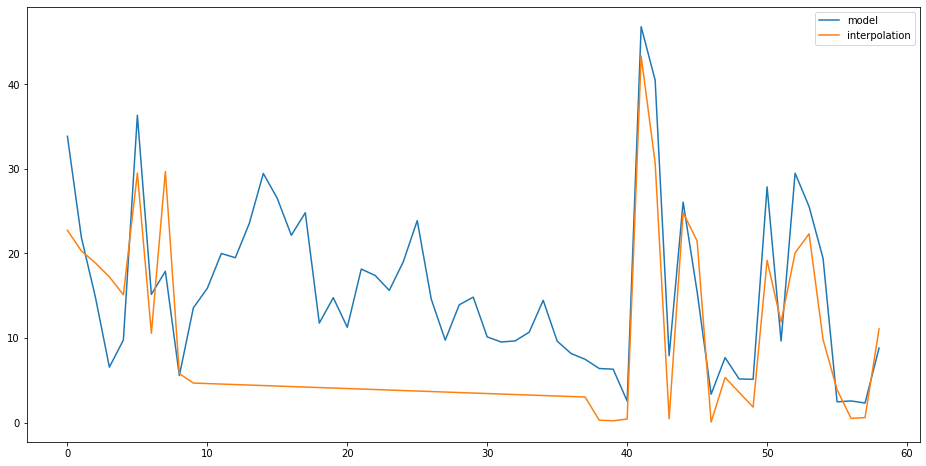

0


In [19]:
park = 'bess'
compare_wind_based_and_interpolation(data, park)
data = num._NumericalDataHandler__insert_missing_values(data, park)
print(data[f'production_{park}'].isna().sum())

#### Skomaker

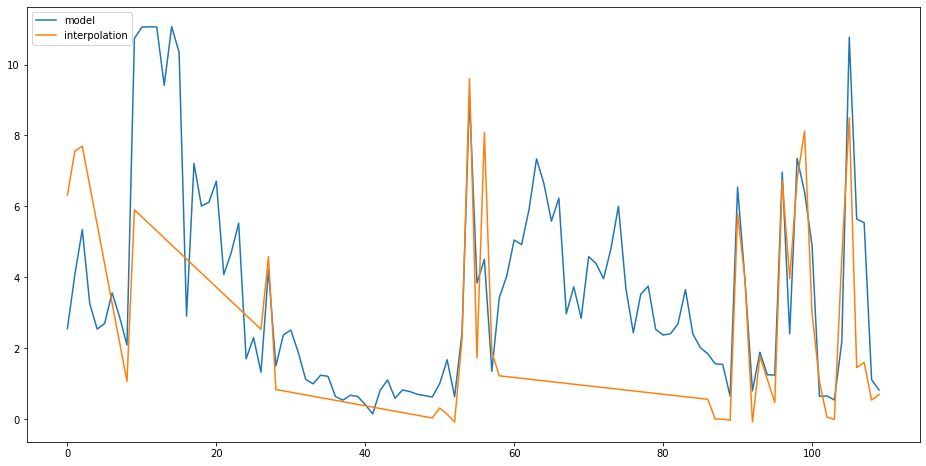

0


In [20]:
park = 'skom'
compare_wind_based_and_interpolation(data, park)
data = num._NumericalDataHandler__insert_missing_values(data, park)
print(data[f'production_{park}'].isna().sum())

#### Valsneset

In [21]:
park = 'vals'
#compare_wind_based_and_interpolation(data, park)
#data = num._NumericalDataHandler__insert_missing_values(data, park)
print(data[f'production_{park}'].isna().sum())

0


#### Yvik

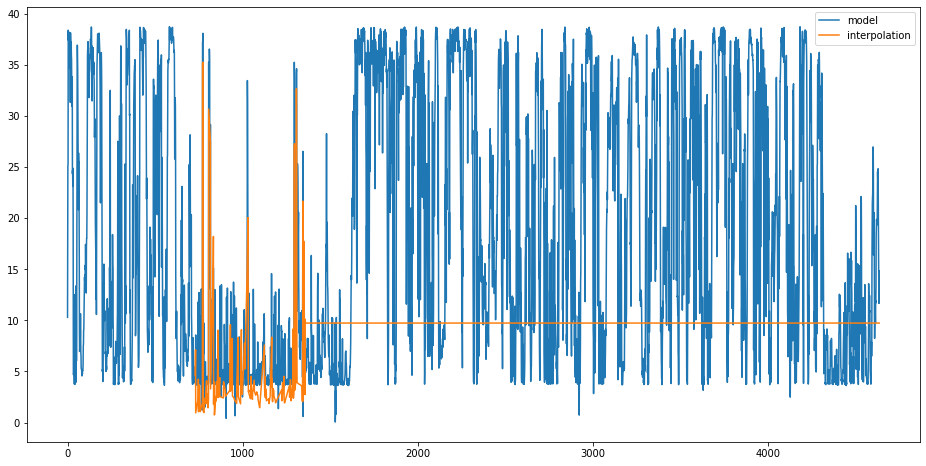

0


In [22]:
park = 'yvik'
compare_wind_based_and_interpolation(data, park)
data = num._NumericalDataHandler__insert_missing_values(data, park)
print(data[f'production_{park}'].isna().sum())

In [23]:
data

,wind_speed_bess,wind_speed_skom,wind_speed_vals,wind_speed_yvik,wind_direction_bess_cos,wind_direction_bess_sin,wind_direction_skom_cos,wind_direction_skom_sin,wind_direction_vals_cos,wind_direction_vals_sin,wind_direction_yvik_cos,wind_direction_yvik_sin,wind_speed_bess+1h,wind_speed_bess+2h,wind_speed_bess+3h,wind_speed_bess+4h,wind_speed_bess+5h,wind_speed_bess+6h,wind_speed_skom+1h,wind_speed_skom+2h,wind_speed_skom+3h,wind_speed_skom+4h,wind_speed_skom+5h,wind_speed_skom+6h,wind_speed_vals+1h,...,wind_direction_vals_cos+4h,wind_direction_vals_cos+5h,wind_direction_vals_cos+6h,wind_direction_vals_sin+1h,wind_direction_vals_sin+2h,wind_direction_vals_sin+3h,wind_direction_vals_sin+4h,wind_direction_vals_sin+5h,wind_direction_vals_sin+6h,wind_direction_yvik_cos+1h,wind_direction_yvik_cos+2h,wind_direction_yvik_cos+3h,wind_direction_yvik_cos+4h,wind_direction_yvik_cos+5h,wind_direction_yvik_cos+6h,wind_direction_yvik_sin+1h,wind_direction_yvik_sin+2h,wind_direction_yvik_sin+3h,wind_direction_yvik_sin+4h,wind_direction_yvik_sin+5h,wind_direction_yvik_sin+6h,production_bess,production_skom,production_vals,production_yvik
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,5.924854,5.924854,11.237959,4.680930,-0.416140,-0.909301,-0.416140,-0.909301,-0.350507,-0.936560,0.993281,-0.115730,7.911698,4.759249,8.756135,7.032285,12.426073,10.642941,7.911698,4.759249,8.756135,7.032285,12.426073,10.642941,12.686844,...,0.999851,0.995575,0.914930,-0.978690,-0.504649,-0.013455,-0.017261,0.093970,0.403613,0.987790,0.987570,0.963999,0.950571,0.950051,0.953721,0.155788,0.157177,-0.265907,0.310507,0.312095,0.300692,32.179571,10.942485,7.868176,10.295235
2017-01-01 01:00:00,7.911698,7.911698,12.686844,6.236224,0.561791,-0.827279,0.561791,-0.827279,-0.205344,-0.978690,0.987790,0.155788,4.759249,8.756135,7.032285,12.426073,10.642941,8.892717,4.759249,8.756135,7.032285,12.426073,10.642941,8.892717,11.224032,...,0.995575,0.914930,0.973572,-0.504649,-0.013455,-0.017261,0.093970,0.403613,0.228381,0.987570,0.963999,0.950571,0.950051,0.953721,0.997853,0.157177,-0.265907,0.310507,0.312095,0.300692,0.065495,28.908418,8.783329,8.407978,18.061003
2017-01-01 02:00:00,4.759249,4.759249,11.224032,7.433258,0.994717,-0.102655,0.994717,-0.102655,0.863324,-0.504649,0.987570,0.157177,8.756135,7.032285,12.426073,10.642941,8.892717,13.332379,8.756135,7.032285,12.426073,10.642941,8.892717,13.332379,12.307698,...,0.914930,0.973572,0.995784,-0.013455,-0.017261,0.093970,0.403613,0.228381,0.091734,0.963999,0.950571,0.950051,0.953721,0.997853,0.999728,-0.265907,0.310507,0.312095,0.300692,0.065495,0.023303,28.208008,7.669333,8.331408,25.196536
2017-01-01 03:00:00,8.756135,8.756135,12.307698,7.441080,0.988941,0.148309,0.988941,0.148309,0.999909,-0.013455,0.963999,-0.265907,7.032285,12.426073,10.642941,8.892717,13.332379,11.829131,7.032285,12.426073,10.642941,8.892717,13.332379,11.829131,13.291807,...,0.973572,0.995784,0.999972,-0.017261,0.093970,0.403613,0.228381,0.091734,0.007441,0.950571,0.950051,0.953721,0.997853,0.999728,0.994425,0.310507,0.312095,0.300692,0.065495,0.023303,-0.105444,17.902952,5.358086,6.826868,25.241700
2017-01-01 04:00:00,7.032285,7.032285,13.291807,13.588820,0.999458,0.032906,0.999458,0.032906,0.999851,-0.017261,0.950571,0.310507,12.426073,10.642941,8.892717,13.332379,11.829131,11.462670,12.426073,10.642941,8.892717,13.332379,11.829131,11.462670,11.270702,...,0.995784,0.999972,0.998308,0.093970,0.403613,0.228381,0.091734,0.007441,-0.058154,0.950051,0.953721,0.997853,0.999728,0.994425,0.999268,0.312095,0.300692,0.065495,0.023303,-0.105444,0.038255,18.196222,5.883873,8.050575,38.384282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30 19:00:00,9.496473,9.496473,7.415377,6.575445,-0.597015,0.802230,-0.597015,0.802230,-0.606798,0.794856,-0.539812,0.841786,10.31805

## Save the current dataframes for further analysis and visualization

In [24]:
data = data.asfreq('H')

In [25]:
# save formatted data
num.write_formatted_data(data, nan=False)